In [47]:
import glob
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
from matplotlib import pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# data prep and model-tuning
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from skopt import BayesSearchCV
from sklearn.metrics import (make_scorer, cohen_kappa_score, 
                             precision_recall_curve, confusion_matrix, 
                             plot_precision_recall_curve, precision_score, 
                             recall_score, f1_score)

# types of models we'll fit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

# some resampling algorithms
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN

# for saving things
import pickle

## Our Data

In [3]:
DATA = '../data/processed/monthly_species_training.csv'
df = pd.read_csv(DATA)
df = df.dropna()
print('{:,d} samples'.format(len(df)))
print('Columns:', df.columns.values)

11,832 samples
Columns: ['lat' 'lon' 'orig_id' 'uuid' 'source' 'meas_yr' 'ecoregion3' 'agency'
 'plot_size_ac' 'year' 'tmax01' 'tmax02' 'tmax03' 'tmax04' 'tmax05'
 'tmax06' 'tmax07' 'tmax08' 'tmax09' 'tmax10' 'tmax11' 'tmax12' 'tmin01'
 'tmin02' 'tmin03' 'tmin04' 'tmin05' 'tmin06' 'tmin07' 'tmin08' 'tmin09'
 'tmin10' 'tmin11' 'tmin12' 'tave01' 'tave02' 'tave03' 'tave04' 'tave05'
 'tave06' 'tave07' 'tave08' 'tave09' 'tave10' 'tave11' 'tave12' 'ppt01'
 'ppt02' 'ppt03' 'ppt04' 'ppt05' 'ppt06' 'ppt07' 'ppt08' 'ppt09' 'ppt10'
 'ppt11' 'ppt12' 'dd_0_01' 'dd_0_02' 'dd_0_03' 'dd_0_04' 'dd_0_05'
 'dd_0_06' 'dd_0_07' 'dd_0_08' 'dd_0_09' 'dd_0_10' 'dd_0_11' 'dd_0_12'
 'dd5_01' 'dd5_02' 'dd5_03' 'dd5_04' 'dd5_05' 'dd5_06' 'dd5_07' 'dd5_08'
 'dd5_09' 'dd5_10' 'dd5_11' 'dd5_12' 'dd_18_01' 'dd_18_02' 'dd_18_03'
 'dd_18_04' 'dd_18_05' 'dd_18_06' 'dd_18_07' 'dd_18_08' 'dd_18_09'
 'dd_18_10' 'dd_18_11' 'dd_18_12' 'dd18_01' 'dd18_02' 'dd18_03' 'dd18_04'
 'dd18_05' 'dd18_06' 'dd18_07' 'dd18_08' 'dd18_09' 

The different types of predictor variables we will use to predict forest composition, including climate, soil, and satellite-derived attributes.

In [4]:
# for using monthly climate attributes
CLIM_COLS = ['dd5_01', 'dd5_02', 'dd5_03', 'dd5_04', 'dd5_05', 'dd5_06',  # growing degree days
             'dd5_07', 'dd5_08', 'dd5_09', 'dd5_10', 'dd5_11', 'dd5_12',  # above 5C
             'dd_18_01', 'dd_18_02', 'dd_18_03', 'dd_18_04', 'dd_18_05', 'dd_18_06',  # growing degree
             'dd_18_07', 'dd_18_08', 'dd_18_09', 'dd_18_10', 'dd_18_11', 'dd_18_12',  # days below 18C
             'eref01', 'eref02', 'eref03', 'eref04', 'eref05', 'eref06',  # reference evaporation
             'eref07', 'eref08', 'eref09', 'eref10', 'eref11', 'eref12', 
             'cmd01', 'cmd02', 'cmd03', 'cmd04', 'cmd05', 'cmd06',   # climatic moisture deficit
             'cmd07', 'cmd08', 'cmd09', 'cmd10', 'cmd11', 'cmd12']

# for using seasonal climate attributes
# CLIM_COLS = ['dd5_wt', 'dd5_sp', 'dd5_sm', 'dd5_at', 
#              'dd_18_wt', 'dd_18_sp', 'dd_18_sm', 'dd_18_at',
#              'eref_wt', 'eref_sp', 'eref_sm', 'eref_at', 
#              'cmd_wt', 'cmd_sp', 'cmd_sm', 'cmd_at']

SOIL_COLS = ['bulk_dens', 'soil_depth', 'pct_clay_surf', 'pct_rock_surf', 'pct_sand_surf']

LANDSAT_COLS = ['green', 'blue', 'red', 'nir', 'endvi', 'ndvi', 'savi',
                'swir1', 'swir2', 'wetness', 'greenness', 'brightness']

MODIS_COLS = ['dormancy', 'evi_amplitude', 'evi_area', 'evi_minimum',
              'greenup', 'maturity', 'midgreendown', 'midgreenup', 
              'numcycles', 'peak']

In [5]:
RANDOM_STATE = 19831207

## Selecting initial features and targets
This is the first step in determining what features we want to use, and what we want to predict. Later, we can still apply some procedures to choose a subset of these features to make simpler models.

We will ultimately try to predict whether or not a species is present and abundant on a plot. This is a classification problem, so we will take the basal area by species and convert it into a series of binary indicators of whether a species (group) could have 10+% canopy cover for a plot. To do so, we first need to establish a threshold above which we think it's likely that more than 10% canopy cover is achieved. We'll do that using logistic regression.

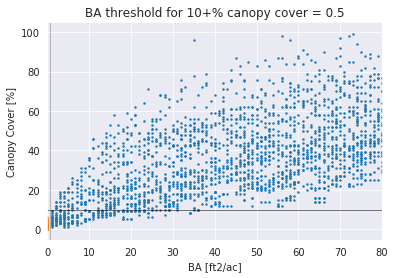

In [6]:
log_reg = LogisticRegression()
log_reg.fit(df.ba.values.reshape(-1, 1), (df.total_cover >= 0.001))
pred = log_reg.predict(df.ba.values.reshape(-1,1))

# plot the ba vs. canopy cover decision
plt.scatter(df.ba[pred], df.total_cover[pred], s=2)
plt.scatter(df.ba[~pred], df.total_cover[~pred], s=2)
plt.xlim(0,80)
plt.xlabel('BA [ft2/ac]')
plt.ylabel('Canopy Cover [%]')
plt.axhline(10, color='black', lw=0.5)
THRESH = 0.50
DEC_BND = ((np.log(THRESH/(1-THRESH)) - log_reg.intercept_) / log_reg.coef_)[0][0]
plt.axvline(DEC_BND, color='gray', lw=0.5)
TITLE = 'BA threshold for 10+% canopy cover = {:,.1f}'.format(DEC_BND)
plt.title(TITLE)
plt.show();

Now we can apply this threshold to all the species-group-level basal areas for the plots to create a binary presence/absence classification for each species group on each plot. 

In [7]:
BA_COLS = ['TRUE_FIR', 'OTHER_HARDWOOD', 'MAPLE', 'OAK', 'DOUGLAS_FIR', 
           'SPRUCE', 'CEDAR', 'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 
           'LODGEPOLE_PINE', 'HEMLOCK', 'RED_ALDER', 'TANOAK', 'JUNIPER',
           'LARCH']

pres_cols = [x + '_pres' for x in BA_COLS]
# spp_presence = log_reg.predict(df[BA_COLS].values.reshape(-1,1)).reshape(df[BA_COLS].shape) * 1
spp_presence = (df[BA_COLS].values.reshape(-1,1) > 0).reshape(df[BA_COLS].shape)*1

spp_presence = pd.DataFrame(data=spp_presence, columns=pres_cols)

If a single species group also occupies more than 1/3 of a plot's basal area, we will call that species abundant. We'll create a categorization where:
* 0 = absent
* 1 = present but not abundant
* 2 = present and abundant.

In [8]:
ba_prop = (df[BA_COLS].values / (df.ba.values.reshape(-1,1) + 1e-9))
abund_cols = [x + '_abund' for x in BA_COLS]
spp_abund = ((ba_prop > 1/3) * spp_presence.values)*1 + spp_presence.values
spp_abund = pd.DataFrame(data=spp_abund, columns=abund_cols)

In [9]:
# merge these presence and abundance classes into the dataframe
df = pd.concat([df, spp_presence, spp_abund], axis=1)

In [10]:
X_COLS = LANDSAT_COLS + CLIM_COLS + MODIS_COLS + SOIL_COLS\
         + ['distance_to_water_m']

## Split the data into training and testing sets
Since some plot_ids have multiple observations, we want all observations for each plot_id to fall entirely in train_set or entirely the training or testing sets because these samples are definitely not independent.

In [11]:
# create training and testing sets for each species group
train_sets = []
test_sets = []

# make sure each plot (uuid) only goes into either train or testing set
uuids = pd.unique(df['uuid'].values)
np.random.seed(RANDOM_STATE)
train0_test1 = np.random.choice((0,1), uuids.shape, p=(0.8,0.2))
train_test_assign = pd.DataFrame(np.dstack((uuids, train0_test1))[0], columns=['uuid', 'train0_test1'])
df_assigned = df.merge(train_test_assign, on='uuid')
    
train = df_assigned.loc[df_assigned['train0_test1'] == 0]
test = df_assigned.loc[df_assigned['train0_test1'] == 1]

In [12]:
X_train, X_test = train[X_COLS], test[X_COLS]
Y_train, Y_test = train[pres_cols + abund_cols], test[pres_cols + abund_cols]

# Splitting Data for Cross-Validation
To help tune models before testing them against the held-out data in the test set. We will employ cross-validation. However, we need to spend a little bit more time to set-up cross-validation to deal with class imbalances.

Many of the classification algorithms we will use are sensitive to imbalanced data (i.e., where one classification label is much more common than another). In our case, relative few species dominate both presences and abundances.

In [13]:
present = (Y_train[abund_cols] > 0).sum(axis=0).values
absent = (Y_train[abund_cols] < 1).sum(axis=0).values
abundant = (Y_train[abund_cols] > 1).sum(axis=0).values
pd.DataFrame(zip(present, abundant, absent), 
             columns = ['present', 'abundant', 'absent'], 
             index=BA_COLS)\
.sort_values(by='present', ascending=False)\
.style.format('{:,d}')

,present,abundant,absent
DOUGLAS_FIR,"7,359","6,191","2,121"
HEMLOCK,"4,055","1,380","5,425"
RED_ALDER,"2,423",676,"7,057"
OTHER_HARDWOOD,"2,231",399,"7,249"
CEDAR,"2,016",445,"7,464"
MAPLE,"1,614",212,"7,866"
TRUE_FIR,"1,598",561,"7,882"
PONDEROSA_PINE,594,367,"8,886"
SPRUCE,448,153,"9,032"
TANOAK,411,123,"9,069"


In [14]:
present = (Y_test[abund_cols] > 0).sum(axis=0).values
absent = (Y_test[abund_cols] < 1).sum(axis=0).values
abundant = (Y_test[abund_cols] > 1).sum(axis=0).values
pd.DataFrame(zip(present, abundant, absent), 
             columns = ['present', 'abundant', 'absent'], 
             index=BA_COLS)\
.sort_values(by='present', ascending=False)\
.style.format('{:,d}')

,present,abundant,absent
DOUGLAS_FIR,"1,763","1,481",589
HEMLOCK,908,317,"1,444"
RED_ALDER,632,180,"1,720"
OTHER_HARDWOOD,528,80,"1,824"
CEDAR,491,100,"1,861"
TRUE_FIR,455,142,"1,897"
MAPLE,356,49,"1,996"
PONDEROSA_PINE,155,92,"2,197"
SPRUCE,123,32,"2,229"
OTHER_SOFTWOOD,113,9,"2,239"


To help our classification algorithms better learn to discriminate between absence, presence, and abundance for species where the overwhelming majority of samples have that species 'absent' class, we will employ a few resampling techniques that resample the data using over- and/or under-sampling to mitigate class imbalances.

In [15]:
class DummyResampler:
    """Does no resampling."""
    def __init__(self, random_state=None, n_jobs=1):
        self.random_state = random_state
        self.n_jobs = n_jobs
        pass
    
    def fit_resample(self, X, y):
        return X, y
    
RESAMPLERS = {'raw': DummyResampler,
              'adasyn': ADASYN,
              'smote': SMOTE,
              'smoteenn': SMOTEENN,
              'ros': RandomOverSampler,
              'ncr': NeighbourhoodCleaningRule
             }

def resample(resampler_name, X, y, **kwargs):
    """Performs resampling of data to mitigate imbalances in target variable observations.
    
    Parameters
    ----------
    resampler_name : string
      Short-hand for resampling algorithm to use. See keys in RESAMPLERS dictionary.
    X : DataFrame
      features
    y : Series or DataFrame
      targets
      
    Returns
    -------
    resampled : 2-tuple of DataFrames
      X_resampled, y_resampled DataFrames 
    
    """
    if resampler_name in ['adasyn', 'smote', 'smoteenn']:
        min_obs = min(np.bincount(y))
        n_neighbors = min(5,min_obs-1)
        
        # adasyn, smote, and smoteenn can fail if the smallest number of class observations 
        # is < 5. Need to reset number of neighbors these algorithms use for resampling in that case.
        if resampler_name == 'adasyn':
            resampler = RESAMPLERS[resampler_name](n_neighbors=n_neighbors, 
                                                   random_state=RANDOM_STATE, **kwargs)
        elif resampler_name == 'smote':
            resampler = RESAMPLERS[resampler_name](k_neighbors=n_neighbors, 
                                                   random_state=RANDOM_STATE)
        elif resampler_name == 'smoteenn':
            resampler = RESAMPLERS[resampler_name](smote=SMOTE(k_neighbors=n_neighbors, 
                                                               random_state=RANDOM_STATE,
                                                               **kwargs
                                                              ), 
                                                   random_state=RANDOM_STATE, **kwargs)
    
    elif resampler_name == 'ros':
        resampler = RESAMPLERS[resampler_name](random_state=RANDOM_STATE)
    elif resampler_name in ['raw', 'ncr']:
        resampler = RESAMPLERS[resampler_name]()
        
    resampled = resampler.fit_resample(X, y)
    
    return resampled

Because resampling generates new samples from the original data, it is important that resampled observations do not show up in more than one fold of the data used in cross-validation. Otherwise, we would end up with highly-correlated data for training and validating models. Since our observations also include multiple years of climate and satellite data for each plot (each plot represented by a uuid), we also need to make sure and keep observations from each plot in separate cross-validation folds. 

In [16]:
def get_indexed_folds(X, num_folds=3, random_state=19831207):
    """Assigns folds to data, respecting plot UUIDs.
    
    Parameters
    ----------
    X : DataFrame
      training data
    num_folds : int
      number of folds to split data for cross-validation
      
    Returns
    -------
    fold_assignments : DataFrame
      DataFrame containing fold assignments with same indexes as original dataset
    """
    X_uuid = df.reindex(X.index)[['uuid']]
    uuids = np.unique(X_uuid)
    
    np.random.seed(random_state)
    folds = np.random.choice(np.arange(num_folds), uuids.shape)
    
    fold_lookup = pd.DataFrame(list(zip(uuids,folds)), columns=['uuid', 'fold'])
    
    fold_assignments = X_uuid.merge(fold_lookup, on='uuid').drop('uuid', axis=1)
    fold_assignments.index = X_uuid.index
    
    return fold_assignments

def oversample_folds(X, y, num_folds=3, resampler_name='adasyn', random_state=19831207):
    """Resamples data within folds to produce training and validation sets
    
    Parameters
    ----------
    X : DataFrame
      features in training data
    y : DataFrame or Series
      target variable
    num_folds : int
      number of folds to employ for building cross-validation datasets
    resampler_name : string
      name of a resampling algorithm that will be employed to resample data
      to mitigate class imbalances. Currently supported resamplers include:
      'adasyn', 'ncr', 'ros', 'smote', 'smoteenn', and 'raw'. 'raw' leaves 
      data without any resampling.
    
    Returns
    -------
    folded : DataFrame
      resampled data including new fields 'fold' and 'train0_val1' which 
      can be used for splitting data during cross_validation
    
    """
    fold_assignments = get_indexed_folds(X, num_folds, random_state)
    folds = np.unique(fold_assignments.values)
    
    train = pd.concat([X,y], axis=1)
    
    df_folds = []
    for fold in folds:
        X_train, y_train = resample(resampler_name, 
                                    X.loc[fold_assignments.query('fold != {}'.format(fold)).index],
                                    y.loc[fold_assignments.query('fold != {}'.format(fold)).index],
                                    n_jobs=-1
                                   )
        train = pd.concat([X_train, y_train], axis=1)
        
        X_val = X.loc[fold_assignments.query('fold == {}'.format(fold)).index]
        y_val = y.loc[fold_assignments.query('fold == {}'.format(fold)).index]
        val = pd.concat([X_val, y_val], axis=1)
        
        for df in [train, val]:
            df['fold'] = fold
        train['train0_val1'] = 0
        val['train0_val1'] = 1
        
        df_folds.append(pd.concat((train, val), axis=0, ignore_index=True))
    
    folded = pd.concat(df_folds, axis=0, ignore_index=True)
        
    return folded

### Make folded training data for each species group
For making binary classifications of presence and abundance (given predicted presence), we'll generate resampled training datasets for each species group using several different resampling algorithms. We mostly apply oversampling algorithms here to generate new samples for the minority classes. 

In [17]:
training_data = {}
for sp in BA_COLS:
    training_data[sp] = {'presence': {}, 'abundance': {}}
    X, y = X_train, Y_train[sp+'_abund']
    for resampler in RESAMPLERS.keys():
        presences = y > 0
        presences.name = 'target'
        folded = oversample_folds(X, 
                                  presences, 
                                  num_folds=3,
                                  resampler_name=resampler)
        training_data[sp]['presence'][resampler] = folded
        
        pres_idx = y[presences].index
        abundances = y.loc[pres_idx] > 1
        abundances.name = 'target'
        folded = oversample_folds(X.loc[pres_idx], 
                                  abundances, 
                                  num_folds=5,
                                  resampler_name=resampler)
        
        training_data[sp]['abundance'][resampler] = folded
        
    print('Done resampling for {}.'.format(sp))

Done resampling for TRUE_FIR.
Done resampling for OTHER_HARDWOOD.
Done resampling for MAPLE.
Done resampling for OAK.
Done resampling for DOUGLAS_FIR.
Done resampling for SPRUCE.
Done resampling for CEDAR.
Done resampling for PONDEROSA_PINE.
Done resampling for OTHER_SOFTWOOD.
Done resampling for LODGEPOLE_PINE.
Done resampling for HEMLOCK.
Done resampling for RED_ALDER.
Done resampling for TANOAK.
Done resampling for JUNIPER.
Done resampling for LARCH.


## Standardize features
Scale all predictive features to have 0 mean and unit variance (subtracting mean, dividing by standard deviation).

In [18]:
x_scaler = StandardScaler()
x_scaler.fit(df[X_COLS])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
kappa_scorer = make_scorer(cohen_kappa_score)

## Pre-configure a few Classification Models

In [20]:
# borrowed directly from Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

np.seterr(divide='ignore', invalid='ignore')
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

Set up some default parameterizations for the models to allow us to fit them more quickly using multiprocessing where necessary.

In [21]:
MODELS = {'rf': {'model': RandomForestClassifier, 
                 'params': dict(n_estimators=1000, max_depth=100, n_jobs=-1, 
                                class_weight='balanced', random_state=RANDOM_STATE)},
          'svm': {'model': SVC, 
                  'params': dict(random_state=RANDOM_STATE, probability=True)},
          'logistic': {'model': LogisticRegression, 
                       'params': dict(max_iter=1000, n_jobs=-1, 
                                      multi_class='multinomial', random_state=RANDOM_STATE)},
          'knn': {'model': KNeighborsClassifier, 
                  'params': dict(n_jobs=-1)},
          'kde': {'model': KDEClassifier,
                  'params': dict()},
          'gbm': {'model': GradientBoostingClassifier, 
                  'params': dict(max_depth=15, n_estimators=250)},
          'adaboost': {'model': AdaBoostClassifier,
                       'params': dict(n_estimators=250)}
         }

In [49]:
def fit_spp_model(sp_name, model_type, model_name, resampler_name=None, cv=False, multiprocess=False):
    """Fits a binary classification model to predict species presence or abundance.
    
    Parameters
    ----------
    sp_name : string
      Name of a single species group
    model_type : string
      Either 'presence' or 'abundance'
    model_name : string
      Model to fit, see MODELS dictionary for supported models
    resampler_name : string
      Resampler to use, see RESAMPLERS dictionary for supported resamplers
    cv : Boolean
      Whether or not to fit multiple models using cross-validation. 
      If False, returns single fitted model. If True, returns list of 
      models fitted to each fold of training data.
     
    Returns
    -------
     mod(s) : model or list of models
      fitted binary classifier(s)
    """    
    model = MODELS[model_name]['model']
    params = MODELS[model_name]['params']
    
    train = training_data[sp_name][model_type]
    
    if not cv:
        X = train['raw'].query('fold == 0')[X_COLS]
        y = train['raw'].query('fold == 0')['target']
        
        if resampler_name is None:
            X_resampled, y_resampled = X, y
        else:
            X_resampled, y_resampled = resample(resampler_name, X, y)
        
        mod = model(**params)    
        mod.fit(x_scaler.transform(X_resampled), y_resampled)
        
        return mod
    
    else:
        folds = pd.unique(train[resampler_name]['fold'])
        
        if multiprocess:
            parallel_params = [(sp_name, model_type, model_name, 
                                resampler_name, fold) for fold in folds]
            with ThreadPool(len(folds)) as p:
                mods = p.map(fit_model_on_fold, parallel_params)
        else:
            mods = []
            for fold in folds:
                fold_train = train[resampler_name].query('fold == {} and train0_val1 == 0'.format(fold))
                X_train, y_train = fold_train[X_COLS], fold_train['target']
                mod = model(**params)
                mod.fit(x_scaler.transform(X_train), y_train)
                mods.append(mod)
        
        return mods

In [50]:
def fit_model_on_fold(run_params):
    sp_name, model_type, model_name, resampler_name, fold = run_params
    
    model = MODELS[model_name]['model']
    params = MODELS[model_name]['params']
    
    train = training_data[sp_name][model_type]
    
    fold_train = train[resampler_name].query('fold == {} and train0_val1 == 0'.format(fold))
    X_train, y_train = fold_train[X_COLS], fold_train['target']
    mod = model(**params)
    mod.fit(x_scaler.transform(X_train), y_train)
    
    return mod 

In [51]:
def cv_val_score(mods, sp_name, model_type, resampler_name='raw', 
                 scorers=[cohen_kappa_score,
                          precision_score,
                          recall_score,
                          f1_score], 
                 threshold=None):
    folds = pd.unique(training_data[sp_name][model_type][resampler_name]['fold'])
    assert len(mods) == len(folds)
    
    val_data = training_data[sp_name][model_type][resampler_name].query('train0_val1 == 1')
    scores = {}
    for scorer in scorers:
        scorer_name = scorer.__name__.split('_score')[0]
        scores[scorer_name] = []
    
    for fold in folds:
        this_fold = val_data.query('fold == {}'.format(fold))
        X_val, y_val = this_fold[X_COLS], this_fold['target']
        
        for scorer in scorers:
            scorer_name = scorer.__name__.split('_score')[0]
            
            if threshold is None:
                if scorer_name in ['f1', 'precision', 'recall']:
                    
                    score = scorer(y_val,
                                   mods[fold].predict(
                                       x_scaler.transform(X_val)),
                                   zero_division=0)
                else:
                    score = scorer(y_val,
                                   mods[fold].predict(
                                       x_scaler.transform(X_val)))
                        
            else:
                if scorer_name in ['f1', 'precision', 'recall']:
                    score = scorer(y_val,
                                   mods[fold].predict_proba(
                                       x_scaler.transform(X_val))[:,1] > threshold,
                                   zero_division=0)
                else:
                    score = scorer(y_val,
                                   mods[fold].predict_proba(
                                       x_scaler.transform(X_val))[:,1] > threshold)
            
            scores[scorer_name].append(score)
    
    return {key:np.mean(scores[key]) for key in scores.keys()}

def get_cohen_score_curves(mods, sp_name, model_type, model_name,
                           resampler_name='raw', thresholds=np.arange(0,1,0.01)):
    """Calculates Cohen's Kappa scores at a range of probability thresholds for 
    a set of binary classification models trained on cross-validation folds.
    
    Parameters
    ----------
    mods : list
      Fitted binary classification models
    sp_name : string
      Name of species group
    model_type : string
      Either 'presence' or 'abundance'
    resampler_name : string
      type of resampler to use, see keys of RESAMPLERS dictionary for options
    thresholds : list-like of numerics
      probability thresholds for positive class to use in scoring
      
    Returns
    -------
    thresholds : array of numerics
      same as provided by the user
    scores : array with shape (n_folds, len(thresholds))
      scores for each fold of the data 
    """
    
    folds = pd.unique(training_data[sp_name][model_type][resampler_name]['fold'])
    assert len(mods) == len(folds)
    
    val_data = training_data[sp_name][model_type][resampler_name].query('train0_val1 == 1')
    scores = [[] for fold in folds]
    
    for fold in folds:
        this_fold = val_data.query('fold == {}'.format(fold))
        X_val, y_val = this_fold[X_COLS], this_fold['target']
        probs = mods[fold].predict_proba(x_scaler.transform(X_val))
        thresholded = np.greater_equal(probs[:,1].reshape(-1,1), 
                                       thresholds.reshape(1,-1))
        for i, thresh in enumerate(thresholds):
            score = cohen_kappa_score(y_val, thresholded[:,i])
            scores[fold].append(score)
    
    return np.array(thresholds), np.array(scores)

def get_max_threshold(thresholds, scores):
    """Calculates the threshold value at which a score is maximized.
    
    Parameters
    ----------
    thresholds : array, shape(n,)
      values corresponding to predict_proba thresholds
    scores : array, shape(num_folds, n)
      scores for n thresholds across num_folds cross-validation folds
    
    Returns
    -------
    max_thresh : numeric
      threshold value at which the score is maximized
    """
    assert thresholds.shape[0] == scores.shape[1]
    mean_scores = np.mean(scores, axis=0)
    max_mean_idx = np.argmax(mean_scores)
    max_thresh = thresholds[max_mean_idx]
    
    return max_thresh
    

In [52]:
# test_mods = fit_spp_model(sp_name='RED_ALDER', 
#                           model_type='abundance', 
#                           model_name='svm', 
#                           resampler_name='adasyn', 
#                           cv=True, n_jobs=5)

In [53]:
# test_thresh, test_cohens = get_cohen_score_curves(mods=test_mods,
#                                                   sp_name='RED_ALDER',
#                                                   model_type='abundance',
#                                                   model_name='svm',
#                                                   resampler_name='adasyn',
#                                                   thresholds=np.arange(0,1,0.01))

# fig, ax = plt.subplots(1)
# mean_cohens = np.mean(test_cohens, axis=0)
# avg_max = np.argmax(mean_cohens)
# ax.plot(test_thresh, mean_cohens, lw=2, c='k')
# ax.scatter(test_thresh[avg_max], mean_cohens[avg_max], c='black', s=30)

# for fold in test_cohens:
#     ax.plot(test_thresh, fold, lw=0.5, c='gray')
#     fold_max = np.argmax(fold)
#     ax.scatter(test_thresh[fold_max], fold[fold_max], c='gray', s=20)
    
# ax.set_title("Optimal Cohen's Kappa across folds at threshold of {:.2f}".format(test_thresh[avg_max]))
# plt.show();

In [54]:
def predict_two_stage(pres_mod, abund_mod, X, sp_name):
    pres_col = sp_name + '_pres'
    abund_col = sp_name + '_abund'
    
    # predict presences
    preds = pres_mod.predict(x_scaler.transform(X))
    pres_proba = pres_mod.predict_proba(x_scaler.transform(X))
    pres_preds = preds > 0
    
    # predict abundances
    abund_preds = abund_mod.predict(x_scaler.transform(X)[pres_preds])
    abund_proba = abund_mod.predict_proba(x_scaler.transform(X)[pres_preds])
    
    preds[preds > 0] += abund_preds
    
    return preds, pres_proba, abund_proba

In [55]:
def display_scores(results):
    score_df = pd.DataFrame.from_records(results, columns=['species', 'resampler', 'cv_cohen_score'])
    display_df = pd.pivot_table(score_df, index='species', columns='resampler', values='cv_cohen_score')
    display(display_df\
    .style.format('{:.2f}')\
    .highlight_max(color='yellow', axis=1, subset=('cohen_kappa')))
    
    return display_df

In [56]:
def fit_bunch_cv(params):
    sp_name, model_type, model_name, resampler_name = params
    
    SCORE_DIR = '../models/composition/sklearn_candidates/'
    score_fname = '{}_{}_cvscores.csv'.format(model_name,
                                              model_type)
    score_keeper = os.path.join(SCORE_DIR, score_fname)
    
    if model_name in ['svm', 'gbm', 'adaboost', 'kde']:
        multiprocess=True
    else:
        multiprocess=False
    
    mods = fit_spp_model(sp_name=sp_name,
                         model_type=model_type,
                         model_name=model_name,
                         resampler_name=resampler_name,
                         cv=True,
                         multiprocess=multiprocess)
    
    # identify the predict_proba threshold that yields
    # the best cohen's kappa score on cv folds
    
    thresholds, cv_scores = get_cohen_score_curves(mods,
                                                   sp_name,
                                                   model_type,
                                                   model_name,
                                                   resampler_name,
                                                   thresholds=np.arange(0,1,0.01))
    
    threshold = get_max_threshold(thresholds, cv_scores)
    
    scores = cv_val_score(mods=mods,
                          sp_name=sp_name,
                          model_type=model_type,
                          resampler_name=resampler_name,
                          scorers=[cohen_kappa_score, 
                                   precision_score,
                                   recall_score,
                                   f1_score],
                          threshold=threshold)
    
    with open(score_keeper, 'a+') as f:
        for scorer in scores.keys():
            f.write('{},{},{},{},{}\n'.format(sp_name,
                                           resampler_name.upper(),
                                           threshold,
                                           scorer,
                                           scores[scorer]))
        
def fit_then_pickle(params):
    sp_name, model_type, model_name, resampler_name = params
    mod = fit_spp_model(sp_name=sp_name,
                        model_type=model_type,
                        model_name=model_name,
                        resampler_name=resampler_name,
                        cv=False)

    # pickle the model
    mod_fname = '{}_{}_{}_{}_classifier.pkl'.format(sp_name, 
                                                    model_type, 
                                                    model_name, 
                                                    resampler_name)
    path_to_file = '../models/composition/sklearn_candidates/{}'.format(mod_fname)
    pickle.dump(mod, open(path_to_file, 'wb'))
    print('.', end='')
    
def read_display_cv_scores(model_name, model_type):
    scorekeeper = '{}_{}_cvscores.csv'.format(model_name, model_type)
    path_to_scorekeeper = os.path.join('../models/composition/sklearn_candidates',
                                       scorekeeper)
    results = pd.read_csv(path_to_scorekeeper)
    score_df = pd.pivot_table(results,
                              index='species',
                              columns=['scorer', 'resampler'],
                              values='score')
    
    thresh_df = pd.pivot_table(results,
                               index=['species'], 
                               columns=['resampler'], 
                               values='threshold')
    print('Cross-validation scores for ')
    display(score_df\
    .style.format('{:.2f}')\
    .highlight_max(color='yellow', axis=1, subset=('cohen_kappa')))
    
    display(thresh_df)

In [57]:
def fit_bunch_of_models(model_name, model_type, resamplers=RESAMPLERS.keys(), n_jobs=1):
    print('Fitting {} models to predict species {}.'.format(model_name.upper(), 
                                                            model_type.upper()))
    
    SCORE_DIR = '../models/composition/sklearn_candidates'
    score_fname = '{}_{}_cvscores.csv'.format(model_name,
                                              model_type)
    score_keeper = os.path.join(SCORE_DIR, score_fname)
    with open(score_keeper, 'w') as f:
        f.write('species,resampler,threshold,scorer,score\n')
            
    for resampler in resamplers:
        print('Fitting {} models with {} resampler.'.format(model_name.upper(), 
                                                            resampler.upper()), 
              end='')
        
        param_list = [[sp, model_type, model_name, resampler] for sp in BA_COLS]
        
        if n_jobs > 1:
            with Pool(n_jobs) as p:
                p.map(fit_bunch_cv, param_list)
                p.map(fit_then_pickle, param_list) 
        
        else:
            for param_set in param_list:
                fit_bunch_cv(param_set)
                fit_then_pickle(param_set)

        print('Done with {} resampler.'.format(resampler.upper()))
    print('Done fitting {} models.'.format(model_name.upper()))

In [38]:
MOD_NAME, MOD_TYPE = 'knn', 'presence'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE)
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting KNN models to predict species PRESENCE.
Fitting KNN models with RAW resampler................Done with RAW resampler.
Fitting KNN models with ADASYN resampler................Done with ADASYN resampler.
Fitting KNN models with SMOTE resampler................Done with SMOTE resampler.
Fitting KNN models with SMOTEENN resampler................Done with SMOTEENN resampler.
Fitting KNN models with ROS resampler................Done with ROS resampler.
Fitting KNN models with NCR resampler................Done with NCR resampler.
Done fitting KNN models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.41,0.41,0.21,0.41,0.41,0.61
DOUGLAS_FIR,0.21,0.41,0.41,0.21,0.21,0.01
HEMLOCK,0.41,0.81,0.41,0.41,0.41,0.61
JUNIPER,0.41,0.21,0.21,0.21,0.41,0.81
LARCH,0.41,0.21,0.01,0.21,0.41,0.61
LODGEPOLE_PINE,0.21,0.21,0.21,0.01,0.21,0.81
MAPLE,0.41,0.61,0.21,0.41,0.41,0.81
OAK,0.61,0.21,0.01,0.41,0.81,0.81
OTHER_HARDWOOD,0.61,0.41,0.21,0.61,0.41,0.81


In [39]:
MOD_NAME, MOD_TYPE = 'knn', 'abundance'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE)
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting KNN models to predict species ABUNDANCE.
Fitting KNN models with RAW resampler................Done with RAW resampler.
Fitting KNN models with ADASYN resampler................Done with ADASYN resampler.
Fitting KNN models with SMOTE resampler................Done with SMOTE resampler.
Fitting KNN models with SMOTEENN resampler................Done with SMOTEENN resampler.
Fitting KNN models with ROS resampler................Done with ROS resampler.
Fitting KNN models with NCR resampler................Done with NCR resampler.
Done fitting KNN models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.61,0.41,0.21,0.61,0.41,0.61
DOUGLAS_FIR,0.21,0.41,0.61,0.21,0.21,0.01
HEMLOCK,0.41,0.61,0.41,0.41,0.41,0.81
JUNIPER,0.41,0.81,0.21,0.81,0.21,0.41
LARCH,0.41,0.41,0.21,0.41,0.41,0.61
LODGEPOLE_PINE,0.61,0.61,0.41,0.61,0.61,0.81
MAPLE,0.21,0.01,0.01,0.41,0.41,0.81
OAK,0.00,0.21,0.00,0.00,0.00,0.00
OTHER_HARDWOOD,0.61,0.41,0.21,0.61,0.61,0.81


In [40]:
MOD_NAME, MOD_TYPE = 'logistic', 'presence'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE)
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting LOGISTIC models to predict species PRESENCE.
Fitting LOGISTIC models with RAW resampler................Done with RAW resampler.
Fitting LOGISTIC models with ADASYN resampler................Done with ADASYN resampler.
Fitting LOGISTIC models with SMOTE resampler................Done with SMOTE resampler.
Fitting LOGISTIC models with SMOTEENN resampler................Done with SMOTEENN resampler.
Fitting LOGISTIC models with ROS resampler................Done with ROS resampler.
Fitting LOGISTIC models with NCR resampler................Done with NCR resampler.
Done fitting LOGISTIC models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.53,0.42,0.28,0.57,0.53,0.73
DOUGLAS_FIR,0.37,0.59,0.64,0.34,0.37,0.21
HEMLOCK,0.54,0.84,0.48,0.54,0.55,0.82
JUNIPER,0.76,0.36,0.11,0.82,0.93,0.96
LARCH,0.71,0.26,0.16,0.81,0.69,0.89
LODGEPOLE_PINE,0.90,0.26,0.16,0.86,0.84,0.95
MAPLE,0.58,0.52,0.30,0.68,0.54,0.85
OAK,0.81,0.22,0.17,0.89,0.76,0.89
OTHER_HARDWOOD,0.51,0.45,0.25,0.52,0.53,0.68


In [41]:
MOD_NAME, MOD_TYPE = 'logistic', 'abundance'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE)
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting LOGISTIC models to predict species ABUNDANCE.
Fitting LOGISTIC models with RAW resampler................Done with RAW resampler.
Fitting LOGISTIC models with ADASYN resampler................Done with ADASYN resampler.
Fitting LOGISTIC models with SMOTE resampler................Done with SMOTE resampler.
Fitting LOGISTIC models with SMOTEENN resampler................Done with SMOTEENN resampler.
Fitting LOGISTIC models with ROS resampler................Done with ROS resampler.
Fitting LOGISTIC models with NCR resampler................Done with NCR resampler.
Done fitting LOGISTIC models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.75,0.48,0.23,0.50,0.69,0.79
DOUGLAS_FIR,0.44,0.72,0.76,0.31,0.44,0.20
HEMLOCK,0.52,0.69,0.44,0.56,0.53,0.78
JUNIPER,0.07,0.54,0.07,0.11,0.06,0.12
LARCH,0.56,0.92,0.46,0.43,0.45,0.75
LODGEPOLE_PINE,0.75,0.72,0.50,0.73,0.69,0.79
MAPLE,0.45,0.19,0.12,0.51,0.40,0.58
OAK,0.91,0.81,0.55,0.81,0.91,0.99
OTHER_HARDWOOD,0.60,0.43,0.31,0.62,0.68,0.80


In [42]:
MOD_NAME, MOD_TYPE = 'rf', 'presence'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE)
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting RF models to predict species PRESENCE.
Fitting RF models with RAW resampler................Done with RAW resampler.
Fitting RF models with ADASYN resampler................Done with ADASYN resampler.
Fitting RF models with SMOTE resampler................Done with SMOTE resampler.
Fitting RF models with SMOTEENN resampler................Done with SMOTEENN resampler.
Fitting RF models with ROS resampler................Done with ROS resampler.
Fitting RF models with NCR resampler................Done with NCR resampler.
Done fitting RF models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.43,0.41,0.28,0.35,0.42,0.61
DOUGLAS_FIR,0.52,0.50,0.64,0.57,0.50,0.34
HEMLOCK,0.49,0.82,0.46,0.50,0.54,0.71
JUNIPER,0.68,0.53,0.49,0.59,0.61,0.78
LARCH,0.16,0.29,0.08,0.17,0.29,0.51
LODGEPOLE_PINE,0.35,0.26,0.14,0.16,0.31,0.39
MAPLE,0.43,0.53,0.30,0.36,0.50,0.73
OAK,0.41,0.20,0.17,0.22,0.41,0.62
OTHER_HARDWOOD,0.45,0.53,0.31,0.38,0.44,0.65


In [43]:
MOD_NAME, MOD_TYPE = 'rf', 'abundance'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE)
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting RF models to predict species ABUNDANCE.
Fitting RF models with RAW resampler................Done with RAW resampler.
Fitting RF models with ADASYN resampler................Done with ADASYN resampler.
Fitting RF models with SMOTE resampler................Done with SMOTE resampler.
Fitting RF models with SMOTEENN resampler................Done with SMOTEENN resampler.
Fitting RF models with ROS resampler................Done with ROS resampler.
Fitting RF models with NCR resampler................Done with NCR resampler.
Done fitting RF models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.43,0.41,0.27,0.35,0.40,0.70
DOUGLAS_FIR,0.55,0.67,0.76,0.68,0.55,0.28
HEMLOCK,0.48,0.70,0.37,0.46,0.48,0.64
JUNIPER,0.11,0.38,0.13,0.18,0.12,0.20
LARCH,0.51,0.69,0.31,0.40,0.43,0.78
LODGEPOLE_PINE,0.52,0.72,0.38,0.43,0.43,0.77
MAPLE,0.38,0.26,0.20,0.30,0.34,0.56
OAK,0.07,0.04,0.03,0.07,0.06,0.73
OTHER_HARDWOOD,0.41,0.40,0.28,0.35,0.42,0.70


In [58]:
MOD_NAME, MOD_TYPE = 'kde', 'presence'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE, n_jobs=len(BA_COLS))
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting KDE models to predict species PRESENCE.
Fitting KDE models with RAW resampler.Done with RAW resampler.
Fitting KDE models with ADASYN resampler.........Done with ADASYN resampler.
Fitting KDE models with SMOTE resampler.Done with SMOTE resampler.
Fitting KDE models with SMOTEENN resampler.Done with SMOTEENN resampler.
Fitting KDE models with ROS resampler........Done with ROS resampler.
Fitting KDE models with NCR resampler.....Done with NCR resampler.
Done fitting KDE models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.61,0.47,0.26,0.59,0.61,0.76
DOUGLAS_FIR,0.38,0.53,0.65,0.38,0.36,0.22
HEMLOCK,0.59,0.87,0.56,0.62,0.55,0.80
JUNIPER,0.96,0.22,0.19,0.99,0.85,0.99
LARCH,0.87,0.29,0.24,0.67,0.87,0.97
LODGEPOLE_PINE,0.83,0.18,0.10,0.79,0.78,0.98
MAPLE,0.73,0.61,0.35,0.73,0.74,0.93
OAK,0.89,0.21,0.17,0.87,0.85,0.87
OTHER_HARDWOOD,0.61,0.60,0.32,0.60,0.63,0.86


In [59]:
MOD_NAME, MOD_TYPE = 'kde', 'abundance'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE, n_jobs=len(BA_COLS))
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting KDE models to predict species ABUNDANCE.
Fitting KDE models with RAW resampler.Done with RAW resampler.
Fitting KDE models with ADASYN resampler................Done with ADASYN resampler.
Fitting KDE models with SMOTE resampler..Done with SMOTE resampler.
Fitting KDE models with SMOTEENN resampler.Done with SMOTEENN resampler.
Fitting KDE models with ROS resampler.Done with ROS resampler.
Fitting KDE models with NCR resampler.Done with NCR resampler.
Done fitting KDE models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.75,0.70,0.51,0.38,0.57,0.94
DOUGLAS_FIR,0.32,0.62,0.68,0.32,0.32,0.08
HEMLOCK,0.55,0.81,0.49,0.62,0.60,0.86
JUNIPER,0.45,0.54,0.30,0.62,0.35,0.02
LARCH,0.68,0.61,0.65,0.68,0.76,0.91
LODGEPOLE_PINE,0.78,0.99,0.56,0.89,0.80,0.99
MAPLE,0.55,0.21,0.13,0.58,0.60,0.76
OAK,0.00,0.00,0.00,0.00,0.00,0.99
OTHER_HARDWOOD,0.64,0.44,0.34,0.73,0.64,0.92


In [60]:
MOD_NAME, MOD_TYPE = 'svm', 'presence'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE, n_jobs=len(BA_COLS))
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting SVM models to predict species PRESENCE.
Fitting SVM models with RAW resampler........Done with RAW resampler.
Fitting SVM models with ADASYN resampler............Done with ADASYN resampler.
Fitting SVM models with SMOTE resampler.....Done with SMOTE resampler.
Fitting SVM models with SMOTEENN resampler.Done with SMOTEENN resampler.
Fitting SVM models with ROS resampler.Done with ROS resampler.
Fitting SVM models with NCR resampler.Done with NCR resampler.
Done fitting SVM models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.58,0.48,0.22,0.61,0.62,0.79
DOUGLAS_FIR,0.32,0.60,0.80,0.28,0.38,0.12
HEMLOCK,0.54,0.84,0.45,0.57,0.60,0.84
JUNIPER,0.05,0.08,0.05,0.02,0.09,0.28
LARCH,0.38,0.07,0.07,0.51,0.43,0.85
LODGEPOLE_PINE,0.85,0.05,0.09,0.90,0.77,0.96
MAPLE,0.63,0.52,0.21,0.77,0.64,0.87
OAK,0.88,0.07,0.06,0.90,0.78,0.81
OTHER_HARDWOOD,0.60,0.58,0.23,0.54,0.63,0.78


In [61]:
MOD_NAME, MOD_TYPE = 'svm', 'abundance'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE, n_jobs=len(BA_COLS))
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting SVM models to predict species ABUNDANCE.
Fitting SVM models with RAW resampler.Done with RAW resampler.
Fitting SVM models with ADASYN resampler.Done with ADASYN resampler.
Fitting SVM models with SMOTE resampler....Done with SMOTE resampler.
Fitting SVM models with SMOTEENN resampler.....Done with SMOTEENN resampler.
Fitting SVM models with ROS resampler...............Done with ROS resampler.
Fitting SVM models with NCR resampler......Done with NCR resampler.
Done fitting SVM models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.66,0.52,0.25,0.68,0.62,0.69
DOUGLAS_FIR,0.29,0.78,0.84,0.31,0.26,0.21
HEMLOCK,0.54,0.75,0.30,0.58,0.51,0.78
JUNIPER,0.31,0.50,0.26,0.38,0.24,0.34
LARCH,0.54,0.89,0.33,0.48,0.55,0.69
LODGEPOLE_PINE,0.57,0.49,0.34,0.47,0.65,0.77
MAPLE,0.60,0.19,0.13,0.53,0.68,0.77
OAK,0.83,0.33,0.24,0.24,0.82,0.86
OTHER_HARDWOOD,0.55,0.41,0.17,0.59,0.63,0.69


In [254]:
score_dfs = []
for csv in glob.glob('../models/composition/sklearn_candidates/*.csv'):
    df = pd.read_csv(csv)
    model_name = os.path.basename(csv).split('_')[0]
    model_type = os.path.basename(csv).split('_')[1]
    df['model_name'] = model_name
    df['model_type'] = model_type
    score_dfs.append(df)
all_scores = pd.concat(score_dfs, axis=0, ignore_index=True)
all_scores.head()

,species,resampler,threshold,scorer,score,model_name,model_type
0,TRUE_FIR,RAW,0.41,cohen_kappa,0.538924,knn,presence
1,TRUE_FIR,RAW,0.41,precision,0.688113,knn,presence
2,TRUE_FIR,RAW,0.41,recall,0.545986,knn,presence
3,TRUE_FIR,RAW,0.41,f1,0.607521,knn,presence
4,OTHER_HARDWOOD,RAW,0.21,cohen_kappa,0.320333,knn,presence


In [279]:
BESTN=10
bestn = all_scores.query('scorer == "cohen_kappa"').groupby(['species', 'model_type'])['score'].nlargest(BESTN).to_frame()

In [280]:
bestn.head()

score
species model_type               
CEDAR   abundance  2484  0.154054
                   2244  0.152701
                   2184  0.141553
                   2304  0.140678
                   2424  0.135277

In [281]:
bestn['model_name'] = all_scores.reindex(bestn.index.get_level_values(-1))['model_name'].values
bestn['resampler'] = all_scores.reindex(bestn.index.get_level_values(-1))['resampler'].values
bestn['threshold'] = all_scores.reindex(bestn.index.get_level_values(-1))['threshold'].values

In [ ]:
BEST_FITS = {'TRUE_FIR': 
             {'abundance': 
              {'models':
               {'svm':}
               {'resampler:'}
                 -- 'svm', 'raw' or 'rf' 'raw'
'presence' -- 

In [282]:
for sp_name in BA_COLS:
    print(sp_name)
    display(bestn.loc[sp_name])
    print('\n\n')

TRUE_FIR


score model_name resampler  threshold
model_type                                               
abundance  3512  0.412105        svm       ROS       0.52
           3392  0.406441        svm     SMOTE       0.51
           3332  0.401308        svm    ADASYN       0.56
           3276  0.393133        svm       RAW       0.25
           2400  0.389755         rf       ROS       0.41
           3572  0.389042        svm       NCR       0.79
           2160  0.386080         rf       RAW       0.35
           3452  0.385345        svm  SMOTEENN       0.61
           2460  0.381567         rf       NCR       0.67
           2340  0.372134         rf  SMOTEENN       0.44
presence   360   0.588641         rf       RAW       0.39
           600   0.583690         rf       ROS       0.45
           660   0.579598         rf       NCR       0.50
           420   0.579109         rf    ADASYN       0.58
           480   0.577827         rf     SMOTE       0.62
           540   0.573271         rf  SMOTEENN       0.76
           1004  0.568984        svm       ROS       0.76
           1052  0.566188        svm       NCR       0.60
           876   0.564872        svm     SMOTE       0.76
           752   0.564717        svm       RAW       0.21




OTHER_HARDWOOD


score model_name resampler  threshold
model_type                                               
abundance  3408  0.286643        svm     SMOTE       0.63
           1984  0.279916   logistic  SMOTEENN       0.80
           1804  0.279018   logistic       RAW       0.31
           3528  0.275857        svm       ROS       0.59
           3348  0.273412        svm    ADASYN       0.55
           2104  0.273048   logistic       NCR       0.43
           2464  0.271567         rf       NCR       0.40
           3044  0.263640        kde     SMOTE       0.64
           3580  0.262405        svm       NCR       0.41
           1924  0.257611   logistic     SMOTE       0.68
presence   604   0.400962         rf       ROS       0.38
           364   0.400679         rf       RAW       0.31
           484   0.393524         rf     SMOTE       0.44
           424   0.392383         rf    ADASYN       0.45
           664   0.363395         rf       NCR       0.53
           3652  0.362142        gbm       RAW       0.03
           3888  0.361370        gbm       ROS       0.09
           1012  0.355456        svm       ROS       0.54
           824   0.347427        svm    ADASYN       0.60
           2596  0.341025        kde    ADASYN       0.61




MAPLE


score model_name resampler  threshold
model_type                                               
abundance  2348  0.191025         rf  SMOTEENN       0.56
           2108  0.185415   logistic       NCR       0.19
           3516  0.179527        svm       ROS       0.53
           2468  0.179506         rf       NCR       0.26
           1988  0.176540   logistic  SMOTEENN       0.58
           3336  0.175444        svm    ADASYN       0.60
           2228  0.171905         rf    ADASYN       0.38
           3460  0.171411        svm  SMOTEENN       0.77
           2168  0.170673         rf       RAW       0.20
           2288  0.169995         rf     SMOTE       0.34
presence   608   0.531119         rf       ROS       0.36
           368   0.529801         rf       RAW       0.30
           488   0.523735         rf     SMOTE       0.50
           428   0.520731         rf    ADASYN       0.43
           1688  0.516999   logistic       ROS       0.68
           1448  0.516877   logistic       RAW       0.30
           668   0.515297         rf       NCR       0.53
           992   0.513088        svm       ROS       0.77
           872   0.510346        svm     SMOTE       0.64
           1748  0.505914   logistic       NCR       0.52




OAK


score model_name resampler  threshold
model_type                                               
abundance  4272  0.223167        gbm       NCR       0.01
           1812  0.207715   logistic       RAW       0.55
           1872  0.196985   logistic    ADASYN       0.91
           2052  0.193908   logistic       ROS       0.81
           1932  0.187005   logistic     SMOTE       0.91
           2112  0.154414   logistic       NCR       0.81
           1992  0.150298   logistic  SMOTEENN       0.99
           4884  0.104738   adaboost  SMOTEENN       0.51
           2232  0.088841         rf    ADASYN       0.07
           2352  0.084875         rf  SMOTEENN       0.73
presence   672   0.405905         rf       NCR       0.20
           372   0.398819         rf       RAW       0.17
           612   0.392611         rf       ROS       0.22
           432   0.391709         rf    ADASYN       0.41
           492   0.385078         rf     SMOTE       0.41
           552   0.381970         rf  SMOTEENN       0.62
           988   0.362894        svm       ROS       0.90
           1452  0.358029   logistic       RAW       0.17
           2800  0.355826        kde       ROS       0.87
           1752  0.354747   logistic       NCR       0.22




DOUGLAS_FIR


score model_name resampler  threshold
model_type                                               
abundance  3596  0.267347        svm       NCR       0.78
           2116  0.263181   logistic       NCR       0.72
           2476  0.252467         rf       NCR       0.67
           1816  0.252041   logistic       RAW       0.76
           3536  0.248489        svm       ROS       0.31
           3296  0.246931        svm       RAW       0.84
           2056  0.245564   logistic       ROS       0.31
           2176  0.244835         rf       RAW       0.76
           2416  0.242297         rf       ROS       0.68
           1996  0.240714   logistic  SMOTEENN       0.20
presence   496   0.488354         rf     SMOTE       0.50
           616   0.487201         rf       ROS       0.57
           376   0.487036         rf       RAW       0.64
           1000  0.485952        svm       ROS       0.28
           436   0.481890         rf    ADASYN       0.52
           884   0.480048        svm     SMOTE       0.38
           676   0.478680         rf       NCR       0.50
           760   0.477292        svm       RAW       0.80
           1696  0.473310   logistic       ROS       0.34
           816   0.473278        svm    ADASYN       0.32




SPRUCE


score model_name resampler  threshold
model_type                                               
abundance  1880  0.217099   logistic    ADASYN       0.68
           1940  0.195567   logistic     SMOTE       0.67
           2060  0.190948   logistic       ROS       0.67
           1820  0.184620   logistic       RAW       0.52
           4104  0.180797        gbm     SMOTE       0.98
           2000  0.177642   logistic  SMOTEENN       0.88
           3424  0.172369        svm  SMOTEENN       0.69
           4044  0.171261        gbm    ADASYN       0.99
           2240  0.169107         rf    ADASYN       0.52
           2180  0.165335         rf       RAW       0.41
presence   380   0.480685         rf       RAW       0.19
           620   0.479381         rf       ROS       0.31
           680   0.473598         rf       NCR       0.34
           500   0.466840         rf     SMOTE       0.48
           440   0.461168         rf    ADASYN       0.53
           560   0.449377         rf  SMOTEENN       0.62
           1460  0.445298   logistic       RAW       0.29
           2816  0.443955        kde       ROS       0.86
           1760  0.443932   logistic       NCR       0.36
           864   0.441266        svm     SMOTE       0.82




CEDAR


score model_name resampler  threshold
model_type                                               
abundance  2484  0.154054         rf       NCR       0.41
           2244  0.152701         rf    ADASYN       0.43
           2184  0.141553         rf       RAW       0.27
           2304  0.140678         rf     SMOTE       0.40
           2424  0.135277         rf       ROS       0.35
           2364  0.134431         rf  SMOTEENN       0.70
           2064  0.122619   logistic       ROS       0.50
           4244  0.121911        gbm       ROS       0.73
           3340  0.120672        svm    ADASYN       0.66
           3464  0.118248        svm  SMOTEENN       0.69
presence   624   0.278384         rf       ROS       0.35
           384   0.278299         rf       RAW       0.28
           444   0.267036         rf    ADASYN       0.43
           504   0.265017         rf     SMOTE       0.42
           3772  0.260906        gbm     SMOTE       0.22
           3712  0.257436        gbm    ADASYN       0.17
           3896  0.249054        gbm       ROS       0.03
           3656  0.236564        gbm       RAW       0.02
           684   0.235891         rf       NCR       0.41
           768   0.231116        svm       RAW       0.22




PONDEROSA_PINE


score model_name resampler  threshold
model_type                                               
abundance  1828  0.440920   logistic       RAW       0.43
           2128  0.433111   logistic       NCR       0.27
           2068  0.427536   logistic       ROS       0.35
           1888  0.412967   logistic    ADASYN       0.42
           1948  0.411149   logistic     SMOTE       0.38
           3508  0.410556        svm       ROS       0.43
           3388  0.406913        svm     SMOTE       0.41
           3548  0.398263        svm       NCR       0.24
           3328  0.392669        svm    ADASYN       0.34
           3432  0.378220        svm  SMOTEENN       0.42
presence   1768  0.661741   logistic       NCR       0.60
           508   0.642157         rf     SMOTE       0.57
           688   0.638523         rf       NCR       0.39
           388   0.635839         rf       RAW       0.24
           568   0.634719         rf  SMOTEENN       0.55
           1708  0.634714   logistic       ROS       0.84
           448   0.633597         rf    ADASYN       0.50
           628   0.631605         rf       ROS       0.32
           968   0.630270        svm       ROS       0.90
           4672  0.630168   adaboost       NCR       0.50




OTHER_SOFTWOOD


score model_name resampler  threshold
model_type                                               
abundance  2012  0.291189   logistic  SMOTEENN       0.79
           4100  0.283786        gbm     SMOTE       0.01
           3248  0.205803        svm       RAW       0.13
           2372  0.205071         rf  SMOTEENN       0.61
           4888  0.195614   adaboost  SMOTEENN       0.51
           4032  0.190849        gbm    ADASYN       0.41
           4168  0.185970        gbm  SMOTEENN       0.99
           3308  0.180369        svm    ADASYN       0.67
           3372  0.180369        svm     SMOTE       0.75
           3444  0.178346        svm  SMOTEENN       0.97
presence   996   0.249871        svm       ROS       0.83
           692   0.248468         rf       NCR       0.19
           632   0.247106         rf       ROS       0.18
           572   0.246105         rf  SMOTEENN       0.68
           392   0.245870         rf       RAW       0.13
           512   0.245361         rf     SMOTE       0.41
           2680  0.241970        kde     SMOTE       0.82
           3832  0.236663        gbm  SMOTEENN       0.90
           2728  0.233053        kde  SMOTEENN       0.89
           2616  0.232528        kde    ADASYN       0.83




LODGEPOLE_PINE


score model_name resampler  threshold
model_type                                               
abundance  3484  0.427242        svm       ROS       0.47
           2256  0.404904         rf    ADASYN       0.52
           3304  0.400169        svm    ADASYN       0.57
           2196  0.388802         rf       RAW       0.38
           2436  0.374693         rf       ROS       0.43
           2316  0.363850         rf     SMOTE       0.43
           3364  0.360186        svm     SMOTE       0.65
           1896  0.311971   logistic    ADASYN       0.75
           3244  0.310476        svm       RAW       0.34
           2376  0.291127         rf  SMOTEENN       0.77
presence   1032  0.436970        svm       NCR       0.05
           924   0.422660        svm  SMOTEENN       0.96
           1476  0.419569   logistic       RAW       0.16
           1776  0.417066   logistic       NCR       0.26
           972   0.413313        svm       ROS       0.90
           852   0.412193        svm     SMOTE       0.77
           792   0.411694        svm    ADASYN       0.85
           2732  0.386117        kde  SMOTEENN       0.98
           1656  0.380584   logistic  SMOTEENN       0.95
           336   0.377299        knn       NCR       0.21




HEMLOCK


score model_name resampler  threshold
model_type                                               
abundance  2200  0.348625         rf       RAW       0.37
           2260  0.336849         rf    ADASYN       0.48
           2320  0.336451         rf     SMOTE       0.48
           2440  0.330207         rf       ROS       0.46
           2500  0.323751         rf       NCR       0.70
           3412  0.310775        svm     SMOTE       0.51
           3352  0.307458        svm    ADASYN       0.54
           1900  0.306933   logistic    ADASYN       0.52
           2080  0.306849   logistic       ROS       0.56
           1840  0.306712   logistic       RAW       0.44
presence   640   0.533513         rf       ROS       0.50
           400   0.529663         rf       RAW       0.46
           460   0.528577         rf    ADASYN       0.49
           520   0.525246         rf     SMOTE       0.54
           3684  0.512434        gbm    ADASYN       0.71
           3876  0.506889        gbm       ROS       0.54
           3648  0.500746        gbm       RAW       0.44
           3740  0.494552        gbm     SMOTE       0.77
           4348  0.485494   adaboost       RAW       0.50
           700   0.484168         rf       NCR       0.82




RED_ALDER


score model_name resampler  threshold
model_type                                               
abundance  1844  0.431687   logistic       RAW       0.42
           2144  0.431525   logistic       NCR       0.70
           2084  0.430348   logistic       ROS       0.59
           3524  0.397431        svm       ROS       0.57
           2024  0.397128   logistic  SMOTEENN       0.86
           1964  0.396609   logistic     SMOTE       0.52
           1904  0.395138   logistic    ADASYN       0.61
           2204  0.391733         rf       RAW       0.32
           2444  0.388823         rf       ROS       0.40
           2504  0.387292         rf       NCR       0.61
presence   704   0.377084         rf       NCR       0.60
           404   0.370398         rf       RAW       0.33
           888   0.370294        svm     SMOTE       0.51
           524   0.367089         rf     SMOTE       0.48
           1008  0.367085        svm       ROS       0.63
           644   0.365793         rf       ROS       0.39
           584   0.365376         rf  SMOTEENN       0.75
           464   0.363965         rf    ADASYN       0.46
           1068  0.363498        svm       NCR       0.64
           1484  0.361264   logistic       RAW       0.36




TANOAK


score model_name resampler  threshold
model_type                                               
abundance  2448  0.354786         rf       ROS       0.33
           2328  0.351414         rf     SMOTE       0.27
           2268  0.347941         rf    ADASYN       0.23
           2508  0.344081         rf       NCR       0.44
           2208  0.329705         rf       RAW       0.21
           2388  0.314284         rf  SMOTEENN       0.46
           4156  0.308308        gbm  SMOTEENN       0.36
           3380  0.278974        svm     SMOTE       0.47
           4280  0.274001        gbm       NCR       0.01
           3320  0.265379        svm    ADASYN       0.47
presence   648   0.624866         rf       ROS       0.31
           408   0.619326         rf       RAW       0.22
           468   0.604739         rf    ADASYN       0.40
           528   0.604443         rf     SMOTE       0.41
           1488  0.592136   logistic       RAW       0.20
           1728  0.592019   logistic       ROS       0.83
           1608  0.588437   logistic     SMOTE       0.75
           708   0.586609         rf       NCR       0.27
           868   0.584625        svm     SMOTE       0.85
           1788  0.583935   logistic       NCR       0.28




JUNIPER


score model_name resampler  threshold
model_type                                               
abundance  4980  0.392727   adaboost       NCR       0.01
presence   592   0.671745         rf  SMOTEENN       0.78
           472   0.663649         rf    ADASYN       0.68
           4592  0.656830   adaboost       ROS       0.52
           652   0.656163         rf       ROS       0.59
           532   0.653927         rf     SMOTE       0.61
           4428  0.651015   adaboost    ADASYN       0.52
           712   0.643129         rf       NCR       0.53
           412   0.640905         rf       RAW       0.49
           3840  0.634742        gbm       ROS       0.77
           3720  0.630403        gbm     SMOTE       0.99




LARCH


score model_name resampler  threshold
model_type                                               
abundance  2396  0.387691         rf  SMOTEENN       0.78
           2516  0.357998         rf       NCR       0.69
           4144  0.353902        gbm  SMOTEENN       0.66
           3436  0.347206        svm  SMOTEENN       0.69
           3556  0.341693        svm       NCR       0.89
           3312  0.339285        svm    ADASYN       0.54
           1976  0.332195   logistic     SMOTE       0.45
           1856  0.329168   logistic       RAW       0.46
           4276  0.321805        gbm       NCR       0.99
           2036  0.320949   logistic  SMOTEENN       0.75
presence   1676  0.463229   logistic  SMOTEENN       0.89
           1796  0.455219   logistic       NCR       0.26
           1496  0.451657   logistic       RAW       0.16
           908   0.449613        svm  SMOTEENN       0.85
           1736  0.446656   logistic       ROS       0.81
           844   0.445564        svm     SMOTE       0.43
           1024  0.443638        svm       NCR       0.07
           964   0.442809        svm       ROS       0.51
           784   0.442536        svm    ADASYN       0.38
           356   0.442198        knn       NCR       0.21

In [268]:
best3

score model_name resampler  threshold
species        model_type                                               
CEDAR          abundance  2484  0.154054         rf       NCR       0.41
                          2244  0.152701         rf    ADASYN       0.43
                          2184  0.141553         rf       RAW       0.27
               presence   624   0.278384         rf       ROS       0.35
                          384   0.278299         rf       RAW       0.28
                          444   0.267036         rf    ADASYN       0.43
DOUGLAS_FIR    abundance  3596  0.267347        svm       NCR       0.78
                          2116  0.263181   logistic       NCR       0.72
                          2476  0.252467         rf       NCR       0.67
               presence   496   0.488354         rf     SMOTE       0.50
                          616   0.487201         rf       ROS       0.57
                          376   0.487036         rf       RAW       0.64
HEMLOCK        abundance  2200  0.348625         rf       RAW       0.37
                          2260  0.336849         rf    ADASYN       0.48
                          2320  0.336451         rf     SMOTE       0.48
               presence   640   0.533513         rf       ROS       0.50
                          400   0.529663         rf       RAW       0.46
                          460   0.528577         rf    ADASYN       0.49
JUNIPER        abundance  4980  0.392727   adaboost       NCR       0.01
               presence   592   0.671745         rf  SMOTEENN       0.78
                          472   0.663649         rf    ADASYN       0.68
                          4592  0.656830   adaboost       ROS       0.52
LARCH          abundance  2396  0.387691         rf  SMOTEENN       0.78
                          2516  0.357998         rf       NCR       0.69
                          4144  0.353902        gbm  SMOTEENN       0.66
               presence   1676  0.463229   logistic  SMOTEENN       0.89
                          1796  0.455219   logistic       NCR       0.26
                          1496  0.451657   logistic       RAW       0.16
LODGEPOLE_PINE abundance  3484  0.427242        svm       ROS       0.47
                          2256  0.404904         rf    ADASYN       0.52
...                                  ...        ...       ...        ...
PONDEROSA_PINE abundance  1828  0.440920   logistic       RAW       0.43
                          2128  0.433111   logistic       NCR       0.27
                          2068  0.427536   logistic       ROS       0.35
               presence   1768  0.661741   logistic       NCR       0.60
                          508   0.642157         rf     SMOTE       0.57
                          688   0.638523         rf       NCR       0.39
RED_ALDER      abundance  1844  0.431687   logistic       RAW       0.42
                          2144  0.431525   logistic       NCR       0.70
                          2084  0.430348   logistic       ROS       0.59
               presence   704   0.377084         rf       NCR       0.60
                          404   0.370398         rf       RAW       0.33
                          888   0.370294        svm     SMOTE       0.51
SPRUCE         abundance  1880  0.217099   logistic    ADASYN       0.68
                          1940  0.195567   logistic     SMOTE       0.67
                          2060  0.190948   logistic       ROS       0.67
               presence   380   0.480685         rf       RAW       0.19
                          620   0.479381         rf       ROS       0.31
                          680   0.473598         rf       NCR       0.34
TANOAK         abundance  2448  0.354786         rf       ROS       0.33
                          2328  0.351414         rf     SMOTE       0.27
                          2268  0.347941         rf    ADASYN       0.23
               presence   648   0.624866         rf       ROS       0.31
                    

In [266]:
best3.groupby(['model_type', 'model_name'])['score'].count()

model_type  model_name
abundance   adaboost       1
            gbm            3
            logistic      16
            rf            14
            svm            9
presence    adaboost       1
            logistic       5
            rf            35
            svm            4
Name: score, dtype: int64

In [69]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GroupKFold

In [177]:
uuid_groups = df.reindex(X_train.index)['uuid'].values
new_X_train, new_Y_train = X_train.reset_index(drop=True), Y_train.reset_index(drop=True)
groupkfold = GroupKFold(n_splits=3)

SP_NAME = 'LODGEPOLE_PINE'
MODEL_TYPE = 'pres'
cv_splitter = groupkfold.split(new_X_train, new_Y_train[SP_NAME+'_'+MODEL_TYPE], uuid_groups)

MODEL_NAME = 'rf'

test_mod1 = MODELS[MODEL_NAME]['model'](**MODELS[MODEL_NAME]['params'])
test_mod1.fit(x_scaler.transform(new_X_train), 
              new_Y_train[SP_NAME+'_'+MODEL_TYPE] > 0)
test_mod2 = MODELS[MODEL_NAME]['model'](**MODELS[MODEL_NAME]['params'])
new_X_resampled, new_Y_resampled = ADASYN().fit_resample(new_X_train, new_Y_train[SP_NAME+'_'+MODEL_TYPE] > 0)
test_mod2.fit(x_scaler.transform(new_X_resampled), new_Y_resampled)
test_log1 = MODELS['logistic']['model'](**MODELS['logistic']['params'])
test_log2 = MODELS['logistic']['model'](**MODELS['logistic']['params'])
test_log1.fit(test_mod1.predict_proba(x_scaler.transform(new_X_train))[:,1].reshape(-1,1), 
              new_Y_train[SP_NAME+'_'+MODEL_TYPE] > 0)
test_log2.fit(test_mod2.predict_proba(x_scaler.transform(new_X_train))[:,1].reshape(-1,1), 
              new_Y_train[SP_NAME+'_'+MODEL_TYPE] > 0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=19831207, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [181]:
test_mod1_probs = test_mod1.predict_proba(x_scaler.transform(X_test))[:,1].reshape(-1,1)
cohen_kappa_score(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0,
                  test_mod1_probs > 0.5)

0.23869521527402027

In [178]:
test_mod1_probs = test_mod1.predict_proba(x_scaler.transform(X_test))[:,1].reshape(-1,1)
cohen_kappa_score(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0,
                  test_log1.predict(test_mod1_probs))

0.25458364080149853

In [190]:
from sklearn.metrics import brier_score_loss
brier_score_loss(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0, 
                 test_mod1_probs)

0.02255262032312925

In [193]:
brier_score_loss(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0, 
                 test_log1.predict(test_mod1_probs))

0.02848639455782313

In [195]:
brier_score_loss.__name__

'brier_score_loss'

In [194]:
brier_score_loss(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0, 
                 cvcal_probs)

0.02412026079046283

In [191]:
brier_score_loss(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0, 
                 test_mod2_probs)

0.031691770833333334

In [192]:
brier_score_loss(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0, 
                 test_log2.predict(test_mod2_probs))

0.0391156462585034

In [182]:
test_mod2_probs = test_mod2.predict_proba(x_scaler.transform(X_test))[:,1].reshape(-1,1)
cohen_kappa_score(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0,
                  test_mod2_probs > 0.5)

0.28440511349031916

In [185]:
test_mod2_probs = test_mod2.predict_proba(x_scaler.transform(X_test))[:,1].reshape(-1,1)
cohen_kappa_score(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0,
                  test_log2.predict(test_mod2_probs))

0.2615535822759756

In [189]:
cvcal_probs = cv_calibrator.predict_proba(x_scaler.transform(X_test))[:,1].reshape(-1,1)
cohen_kappa_score(Y_test[SP_NAME+'_'+MODEL_TYPE] > 0,
                  cvcal_probs > 0.5)

0.19050851346571207

In [186]:
base_model = MODELS[MODEL_NAME]['model'](**MODELS[MODEL_NAME]['params'])
cv_calibrator = CalibratedClassifierCV(base_model, cv=cv_splitter)
cv_calibrator.fit(x_scaler.transform(new_X_train), new_Y_train[SP_NAME+'_'+MODEL_TYPE])

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=100,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                          

In [172]:
from sklearn.calibration import calibration_curve

test_mod1_probs = test_mod1.predict_proba(x_scaler.transform(X_train))[:,1]
log_probs = test_log1.predict_proba(test_mod1_probs.reshape(-1,1))[:,1]
cvcal_probs = cv_calibrator.predict_proba(x_scaler.transform(X_train))[:,1]
test_mod2_probs = test_mod2.predict_proba(x_scaler.transform(X_train))[:,1]
rf_cal_curve = calibration_curve(Y_train[SP_NAME+'_'+MODEL_TYPE], test_mod1_probs, n_bins=10)
rf2_cal_curve = calibration_curve(Y_train[SP_NAME+'_'+MODEL_TYPE], test_mod2_probs, n_bins=10)
rflog_cal_curve = calibration_curve(Y_train[SP_NAME+'_'+MODEL_TYPE], log_probs, n_bins=10)
cvcal_curve = calibration_curve(Y_train[SP_NAME+'_'+MODEL_TYPE], cvcal_probs, n_bins=10)

In [200]:
MOD_NAME, MOD_TYPE = 'gbm', 'presence'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE, n_jobs=len(BA_COLS))
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting GBM models to predict species PRESENCE.
Fitting GBM models with RAW resampler.........Done with RAW resampler.
Fitting GBM models with ADASYN resampler..Done with ADASYN resampler.
Fitting GBM models with SMOTE resampler........Done with SMOTE resampler.
Fitting GBM models with SMOTEENN resampler....Done with SMOTEENN resampler.
Fitting GBM models with ROS resampler........Done with ROS resampler.
Fitting GBM models with NCR resampler....Done with NCR resampler.
Done fitting GBM models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.17,0.41,0.02,0.03,0.22,0.96
DOUGLAS_FIR,0.37,0.40,0.90,0.82,0.56,0.09
HEMLOCK,0.71,0.99,0.44,0.54,0.77,0.99
JUNIPER,0.98,0.01,0.01,0.77,0.99,0.87
LARCH,0.01,0.03,0.01,0.01,0.02,0.08
LODGEPOLE_PINE,0.08,0.95,0.01,0.01,0.03,0.74
MAPLE,0.07,0.55,0.02,0.13,0.20,0.98
OAK,0.89,0.02,0.03,0.03,0.35,0.98
OTHER_HARDWOOD,0.34,0.72,0.03,0.09,0.28,0.88


In [201]:
MOD_NAME, MOD_TYPE = 'gbm', 'abundance'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE, n_jobs=len(BA_COLS))
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting GBM models to predict species ABUNDANCE.
Fitting GBM models with RAW resampler.Done with RAW resampler.
Fitting GBM models with ADASYN resampler.Done with ADASYN resampler.
Fitting GBM models with SMOTE resampler.........Done with SMOTE resampler.
Fitting GBM models with SMOTEENN resampler.Done with SMOTEENN resampler.
Fitting GBM models with ROS resampler.Done with ROS resampler.
Fitting GBM models with NCR resampler........Done with NCR resampler.
Done fitting GBM models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.07,0.36,0.08,0.73,0.02,0.75
DOUGLAS_FIR,0.91,0.90,0.98,0.98,0.68,0.01
HEMLOCK,0.37,0.99,0.16,0.02,0.43,0.99
JUNIPER,0.01,0.02,0.01,0.01,0.01,0.01
LARCH,0.56,0.99,0.99,0.10,0.98,0.66
LODGEPOLE_PINE,0.09,0.97,0.83,0.92,0.93,0.06
MAPLE,0.18,0.06,0.01,0.04,0.03,0.98
OAK,0.19,0.01,0.00,0.00,0.00,0.57
OTHER_HARDWOOD,0.52,0.92,0.02,0.01,0.04,0.97


In [202]:
MOD_NAME, MOD_TYPE = 'adaboost', 'presence'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE, n_jobs=len(BA_COLS))
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting ADABOOST models to predict species PRESENCE.
Fitting ADABOOST models with RAW resampler.Done with RAW resampler.
Fitting ADABOOST models with ADASYN resampler.Done with ADASYN resampler.
Fitting ADABOOST models with SMOTE resampler...Done with SMOTE resampler.
Fitting ADABOOST models with SMOTEENN resampler..Done with SMOTEENN resampler.
Fitting ADABOOST models with ROS resampler.Done with ROS resampler.
Fitting ADABOOST models with NCR resampler.Done with NCR resampler.
Done fitting ADABOOST models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.50,0.50,0.50,0.50,0.50,0.50
DOUGLAS_FIR,0.50,0.50,0.50,0.50,0.50,0.50
HEMLOCK,0.50,0.50,0.50,0.50,0.50,0.50
JUNIPER,0.52,0.52,0.51,0.52,0.53,0.53
LARCH,0.50,0.49,0.49,0.50,0.50,0.50
LODGEPOLE_PINE,0.50,0.50,0.50,0.50,0.50,0.50
MAPLE,0.50,0.50,0.50,0.50,0.50,0.50
OAK,0.50,0.50,0.50,0.50,0.50,0.50
OTHER_HARDWOOD,0.50,0.50,0.50,0.50,0.50,0.50


In [203]:
MOD_NAME, MOD_TYPE = 'adaboost', 'abundance'
fit_bunch_of_models(model_name=MOD_NAME, model_type=MOD_TYPE, n_jobs=len(BA_COLS))
read_display_cv_scores(MOD_NAME, MOD_TYPE)

Fitting ADABOOST models to predict species ABUNDANCE.
Fitting ADABOOST models with RAW resampler..Done with RAW resampler.
Fitting ADABOOST models with ADASYN resampler.Done with ADASYN resampler.
Fitting ADABOOST models with SMOTE resampler.Done with SMOTE resampler.
Fitting ADABOOST models with SMOTEENN resampler..Done with SMOTEENN resampler.
Fitting ADABOOST models with ROS resampler..Done with ROS resampler.
Fitting ADABOOST models with NCR resampler..Done with NCR resampler.
Done fitting ADABOOST models.
Cross-validation scores for 


resampler,ADASYN,NCR,RAW,ROS,SMOTE,SMOTEENN
species,,,,,,
CEDAR,0.50,0.50,0.50,0.50,0.50,0.50
DOUGLAS_FIR,0.50,0.50,0.50,0.50,0.50,0.50
HEMLOCK,0.50,0.50,0.50,0.50,0.50,0.50
JUNIPER,0.01,0.01,0.01,0.01,0.01,0.01
LARCH,0.50,0.52,0.49,0.50,0.49,0.56
LODGEPOLE_PINE,0.51,0.53,0.51,0.50,0.52,0.52
MAPLE,0.50,0.50,0.49,0.50,0.50,0.50
OAK,0.39,0.40,0.42,0.42,0.42,0.51
OTHER_HARDWOOD,0.50,0.50,0.50,0.50,0.50,0.50


In [ ]:
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support

In [ ]:
rept = classification_report_imbalanced(y_test['CEDAR_abund'], 
                                 test_clf.predict(x_scaler.transform(x_test)), 
                                 target_names=['absent', 'present', 'abundant'])
print(rept)